In [1]:
#导入要用的包
import tensorflow as tf 
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
print("tf version:{}".format(tf.__version__)) #查看一下tensorflow版本


tf version:1.14.0


# 步骤1：搭建循环神经网络RNN


In [2]:

# 先设置一下模型会用到的参数
n_steps = 100 # batch_size,训练一次用多少数据
n_iterations = 900  #迭代次数
n_inputs = 1 # 输入的维度
n_outputs = 1 # 输出的维度
learning_rate = 0.0001 # 学习率

#清空计算图
tf.reset_default_graph()

#定义模型的输入输出及其维度
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#tf里面已经有封装好的基本RNN，直接调用
cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicRNNCell(num_units=128, activation=tf.nn.relu), #因为数据是非线性的，所以设置relu作为激活函数
         output_size=n_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
loss = tf.reduce_mean(tf.square(outputs - y)) #定义模型的损失函数为均方误差
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #选择更新参数的方法为adam
training_op = optimizer.minimize(loss) #最小化损失函数

#会输出一些警告，这是由于版本问题，不影响代码逻辑

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# 步骤2：生成一组时间序列数据

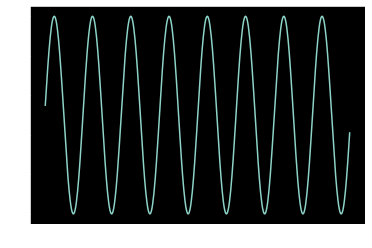

In [3]:
#设置一些变量方便改动
minimum = 0
maximum = 60
data_points = np.linspace(minimum, maximum, (maximum-minimum)*10) #产生(maximum-minimum)*10个数据点
dataset = np.sin(data_points)

#一般在训练神经网络前，我们会对数据做归一化处理，可以加快收敛速度
dataset = dataset.reshape(-1,1) # 转换成scaler.fit_transform 函数要求的形式
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset = dataset.reshape(-1,) # 归一化后把数据维度转换回来


#这里定义一个函数，将数据转换成我们训练模型所需要的数据格式
def create_training_dataset(dataset, n_steps, n_outputs):
    dataX, dataY = [], []
    for i in range(500):  
        x = dataset[i]
        y = dataset[i+1]
        dataX.append(x)
        dataY.append(y)
    dataX, dataY =  np.array(dataX), np.array(dataY)
    dataX = np.reshape(dataX, (-1, n_steps, n_outputs))
    dataY = np.reshape(dataY, (-1, n_steps, n_outputs))    
    return dataX, dataY

dataX, dataY = create_training_dataset(dataset, n_steps, n_outputs) #得到训练数据
plt.plot(dataY.reshape(-1,)) #画出数据趋势，也就是我们希望RNN要学习到的趋势

# 步骤3：训练RNN并进行预测

0 	 MSE 0.41462648
150 	 MSE 0.0058930297
300 	 MSE 0.0030124884
450 	 MSE 0.0022604037
600 	 MSE 0.0017875385
750 	 MSE 0.0014299514


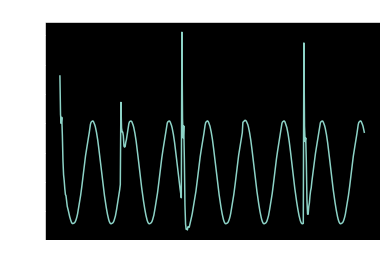

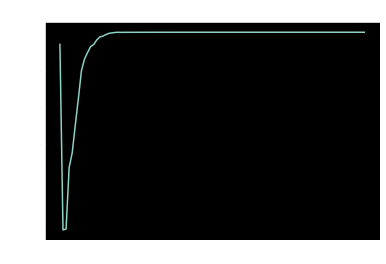

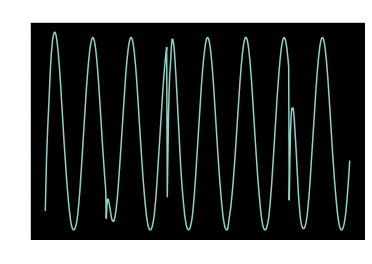

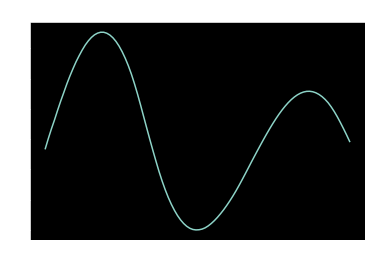

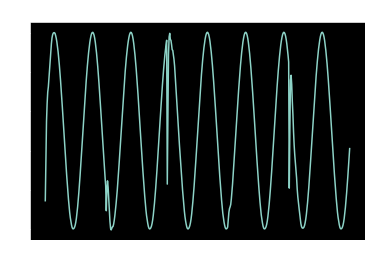

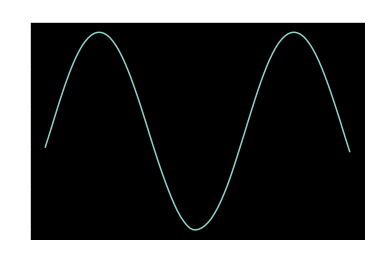

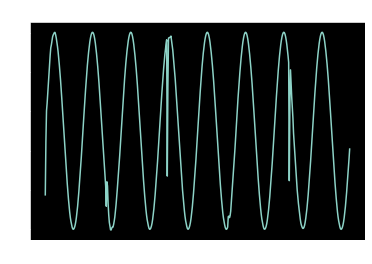

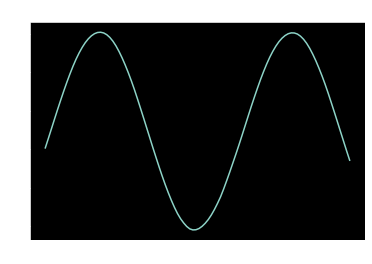

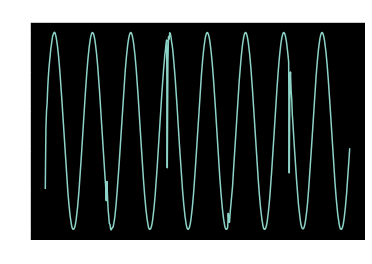

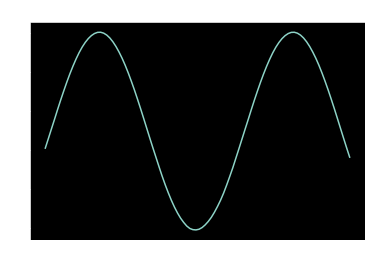

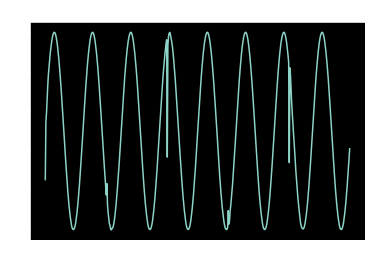

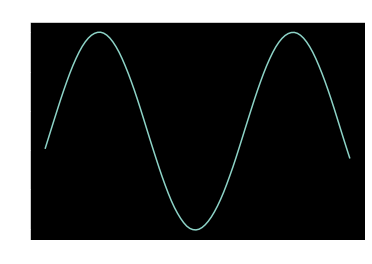

In [4]:

# 初始化变量，下面的流程可以理解为Tensorflow训练过程的一种标准模板
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run() #按照模型的结构进行运算
    for iteration in range(n_iterations):
        X_batch, y_batch = dataX, dataY
        _, prediction =sess.run((training_op, outputs), feed_dict={X: X_batch, y: y_batch})

        if iteration % 150 == 0: #每迭代150次输出一下均方误差，查看训练情况
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\t MSE", mse)
            # 将预测结果展开成1维的
            prediction = np.reshape(prediction, (-1,))
            #将拟合情况画图
            plt.plot(prediction)
            plt.title('After {} training, fitting result'.format(iteration))
            plt.show()

            #对数据进行预测，并画图
            num_batches = X_batch.shape[0]
            sequence = X_batch[num_batches-1,:,:].reshape(-1).tolist()#取最后一个batch的数据

            prediction_iter = 100 #想要预测的长度
            for iteration in range(prediction_iter):
                X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1) #输入值
                y_pred = sess.run(outputs, feed_dict={X: X_batch}) #预测值
                sequence.append(y_pred[0, -1, 0])
            plt.plot(sequence[-prediction_iter:])
            plt.title('prediction'.format(iteration))
            plt.show()